## Project 5 - Predicting COVID with Chest X-Rays

In [40]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import imageio
import PIL
from PIL import Image
import os
from pandas import DataFrame

#modelling imports
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision
from sklearn.metrics import classification_report
from keras.applications import MobileNetV2, VGG16, InceptionV3, Xception
from keras.layers import GlobalAveragePooling2D
from keras.utils import to_categorical

#### Reading in the images and making a dataframe for later use

In [6]:
#read in photos with ImageDataGenerator
#image io, os, pillow

In [3]:
os.getcwd()

'/Users/melissamcmillan/Documents/Python_Stuff/GA_DSI_Course/Project_5/AIRadiologists'

In [4]:
files = os.listdir('COVID-19 Radiography Database Split/TRAIN/COVID_train/')
print(len(files))

961


In [9]:
#make covid_images your variable to the directory where you have stored the COVID x-ray images
covid_images = 'COVID-19 Radiography Database Split/TRAIN/COVID_train/'

#this will loop through the images in the covid directory and add each image to the master list
covid_files = []
for filename in os.listdir(covid_images):
    if filename.endswith(".png"): 
         # print(os.path.join(directory, filename))
        covid_files.append(filename)

#check the length of the master list to make sure it's what we expect; should return 1200 in this case
len(covid_files)

960

In [10]:
#make normal_images your variable to the directory where you have stored the COVID x-ray images
normal_images = 'COVID-19 Radiography Database Split/TRAIN/NORMAL_train/'

#this will loop through the images in the covid directory and add each image to the master list
normal_files = []
for filename in os.listdir(normal_images):
    if filename.endswith(".png"): 
         # print(os.path.join(directory, filename))
        normal_files.append(filename)

#check the length of the master list to make sure it's what we expect; should return 1200 in this case
len(normal_files)

1073

In [11]:
#make covid_images your variable to the directory where you have stored the COVID x-ray images
pneum_images = 'COVID-19 Radiography Database Split/TRAIN/Viral_Pneumonia_train/'

#this will loop through the images in the covid directory and add each image to the master list
pneum_files = []
for filename in os.listdir(pneum_images):
    if filename.endswith(".png"): 
         # print(os.path.join(directory, filename))
        pneum_files.append(filename)

#check the length of the master list to make sure it's what we expect; should return 1200 in this case
len(pneum_files)

1076

In [15]:
#now making a master list for all the images
master_list = []
for element in covid_files:
    master_list.append(Image.open(covid_images + element))
for element in normal_files:
    master_list.append(Image.open(normal_images + element))
for element in pneum_files:
    master_list.append(Image.open(pneum_images + element))
len(master_list)

3109

In [16]:
#now making a master dataframe for all of our train images
images_df = DataFrame(master_list, columns = ['images'])
images_df['type'] = 'covid'
images_df

,images,type
0,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
1,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
2,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
3,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
4,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
...,...,...
3104,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
3105,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
3106,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
3107,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid


In [20]:
#fixing the type labels to match the data
images_df['type'].iloc[960:2032] = 'normal'
images_df['type'].iloc[2033:] = 'pneumonia'
images_df

,images,type
0,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
1,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
2,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
3,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
4,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
...,...,...
3104,<PIL.PngImagePlugin.PngImageFile image mode=L ...,pneumonia
3105,<PIL.PngImagePlugin.PngImageFile image mode=L ...,pneumonia
3106,<PIL.PngImagePlugin.PngImageFile image mode=L ...,pneumonia
3107,<PIL.PngImagePlugin.PngImageFile image mode=L ...,pneumonia


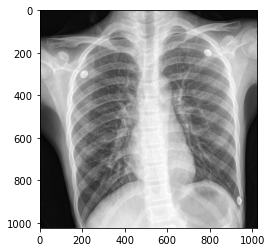

In [22]:
plt.imshow(images_df['images'].iloc[-1], cmap = 'gray')

#### Ready to Start the Modelling

##### Making a Null Model

In [24]:
#we are going to use the value counts to figure out which class has the most images in our train set, then use that number as our null:
images_df['type'].value_counts(normalize=True)

pneumonia    0.346092
normal       0.344805
covid        0.309103
Name: type, dtype: float64

In [ ]:
#It looks like our null is viral_pneumonia, and our baseline is ~35%

##### Model 1: Testing initial hyperparams in the ImageDataGenerator

In [25]:
#load all images
#directory parameter == file path! make sure the relative path is correct!
#create a train dataset from the generator
#create a test dataset for evaluation
#label the batch_size for use later in the code

#data augmentation
image_generator = ImageDataGenerator(rescale = 1./255,
                                  validation_split = .1,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    brightness_range=(0.5,.75))

test_datagen = ImageDataGenerator(rescale = 1./255)


bat_size = 32

train_data = image_generator.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TRAIN',
                                                 class_mode='categorical',
                                                 color_mode='grayscale',
                                                 subset = 'training',
                                                 target_size=(256,256),
                                                 batch_size=bat_size)

#create a validation dataset from the generator
val_data = image_generator.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TRAIN',
                                                      class_mode='categorical',
                                                      color_mode='grayscale',
                                                      subset='validation',
                                                      target_size=(256,256),
                                                      batch_size=bat_size)
#pull in the test data from the directory
test_data = test_datagen.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TEST',
                                            class_mode = 'categorical',
                                            color_mode='grayscale',
                                            target_size = (256,256),
                                             batch_size = bat_size)

Found 2799 images belonging to 3 classes.
Found 310 images belonging to 3 classes.
Found 777 images belonging to 3 classes.


In [26]:
#create the neural network
model1 = Sequential()

model1.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,1)))
model1.add(MaxPool2D(pool_size = (2,2)))

model1.add(Flatten())
model1.add(Dense(300, activation = 'relu'))
model1.add(Dense(3, activation='softmax'))

#compile the model
model1.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['acc', 'Recall'])

In [27]:
#fit the generator to the model
history1 = model1.fit_generator(train_data,
                   validation_data = val_data,
                   steps_per_epoch = train_data.n//train_data.batch_size,
                   validation_steps = val_data.n//val_data.batch_size,
                   epochs = 15)

/Users/melissamcmillan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
87/87 [==============================] - 101s 1s/step - loss: 5.1680 - acc: 0.6427 - recall: 0.6184 - val_loss: 0.2479 - val_acc: 0.9062 - val_recall: 0.9028
Epoch 2/15
87/87 [==============================] - 84s 958ms/step - loss: 0.2941 - acc: 0.8986 - recall: 0.8874 - val_loss: 0.1794 - val_acc: 0.9444 - val_recall: 0.9444
Epoch 3/15
87/87 [==============================] - 78s 894ms/step - loss: 0.1975 - acc: 0.9263 - recall: 0.9194 - val_loss: 0.1464 - val_acc: 0.9479 - val_recall: 0.9479
Epoch 4/15
87/87 [==============================] - 78s 898ms/step - loss: 0.1375 - acc: 0.9492 - recall: 0.9463 - val_loss: 0.1592 - val_acc: 0.9271 - val_recall: 0.9236
Epoch 5/15
87/87 [==============================] - 77s 887ms/step - loss: 0.1230 - acc: 0.9602 - recall: 0.9580 - val_loss: 0.1023 - val_acc: 0.9583 - val_recall: 0.9583
Epoch 6/15
87/87 [==============================] - 77s 887ms/step - loss: 0.1016 - acc: 0.9720 - recall: 0.9690 - val_loss: 0.1070 - val_acc: 0.96

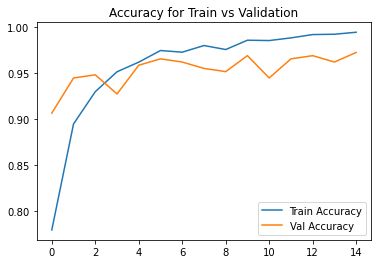

In [28]:
plt.plot(history1.history['acc'], label='Train Accuracy')
plt.plot(history1.history['val_acc'], label='Val Accuracy')
plt.title('Accuracy for Train vs Validation')
plt.legend();

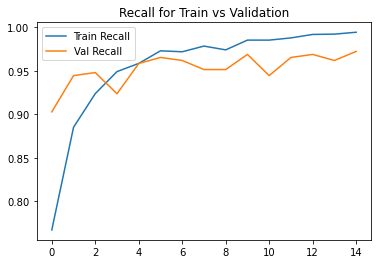

In [29]:
plt.plot(history1.history['recall'], label='Train Recall')
plt.plot(history1.history['val_recall'], label='Val Recall')
plt.title('Recall for Train vs Validation')
plt.legend();

In [30]:
model1.evaluate(test_data)

25/25 [==============================] - 9s 371ms/step - loss: 0.1946 - acc: 0.9434 - recall: 0.9434


[0.19464752078056335, 0.9433719515800476, 0.9433719515800476]

In [ ]:
#Model 1 is our best model--- here is the code to export it

In [ ]:
#save the model
#model1.save('model1_cnn_31Jan2021_best')

##### Model 2: Testing if adding an additional Edge Detection layer improves our model, and reducing the nodes to 100 in the Dense layer.

In [31]:
#load all images
#directory parameter == file path! make sure the relative path is correct!
#create a train dataset from the generator
#create a test dataset for evaluation
#label the batch_size for use later in the code

#data augmentation
image_generator = ImageDataGenerator(rescale = 1./255,
                                  validation_split = .1,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    brightness_range=(0.5,.75))

test_datagen = ImageDataGenerator(rescale = 1./255)


bat_size = 32

train_data = image_generator.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TRAIN',
                                                 class_mode='categorical',
                                                 color_mode='grayscale',
                                                 subset = 'training',
                                                 target_size=(256,256),
                                                 batch_size=bat_size)

#create a validation dataset from the generator
val_data = image_generator.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TRAIN',
                                                      class_mode='categorical',
                                                      color_mode='grayscale',
                                                      subset='validation',
                                                      target_size=(256,256),
                                                      batch_size=bat_size)
#pull in the test data from the directory
test_data = test_datagen.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TEST',
                                            class_mode = 'categorical',
                                            color_mode='grayscale',
                                            target_size = (256,256),
                                             batch_size = bat_size)

Found 2799 images belonging to 3 classes.
Found 310 images belonging to 3 classes.
Found 777 images belonging to 3 classes.


In [32]:
#create the neural network
model2 = Sequential()

model2.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,1)))
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,1)))
model2.add(MaxPool2D(pool_size = (2,2)))

model2.add(Flatten())
model2.add(Dense(100, activation = 'relu'))
model2.add(Dense(3, activation='softmax'))

#compile the model
model2.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['acc', 'Recall'])

In [33]:
#fit the generator to the model
history2 = model2.fit_generator(train_data,
                   validation_data = val_data,
                   steps_per_epoch = train_data.n//train_data.batch_size,
                   validation_steps = val_data.n//val_data.batch_size,
                   epochs = 15)

Epoch 1/15
87/87 [==============================] - 75s 850ms/step - loss: 1.2585 - acc: 0.5695 - recall: 0.3922 - val_loss: 0.2248 - val_acc: 0.9201 - val_recall: 0.9201
Epoch 2/15
87/87 [==============================] - 67s 770ms/step - loss: 0.2834 - acc: 0.8995 - recall: 0.8927 - val_loss: 0.1666 - val_acc: 0.9479 - val_recall: 0.9479
Epoch 3/15
87/87 [==============================] - 61s 695ms/step - loss: 0.2873 - acc: 0.9029 - recall: 0.8947 - val_loss: 0.2584 - val_acc: 0.9062 - val_recall: 0.8993
Epoch 4/15
87/87 [==============================] - 61s 700ms/step - loss: 0.2178 - acc: 0.9216 - recall: 0.9173 - val_loss: 0.1402 - val_acc: 0.9583 - val_recall: 0.9583
Epoch 5/15
87/87 [==============================] - 62s 710ms/step - loss: 0.1556 - acc: 0.9409 - recall: 0.9387 - val_loss: 0.1393 - val_acc: 0.9444 - val_recall: 0.9444
Epoch 6/15
87/87 [==============================] - 62s 707ms/step - loss: 0.1478 - acc: 0.9511 - recall: 0.9478 - val_loss: 0.1298 - val_acc: 0.

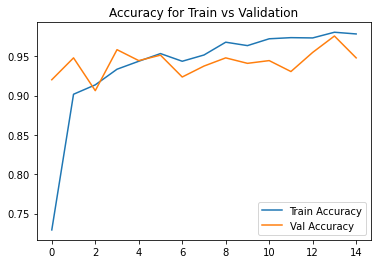

In [34]:
plt.plot(history2.history['acc'], label='Train Accuracy')
plt.plot(history2.history['val_acc'], label='Val Accuracy')
plt.title('Accuracy for Train vs Validation')
plt.legend();

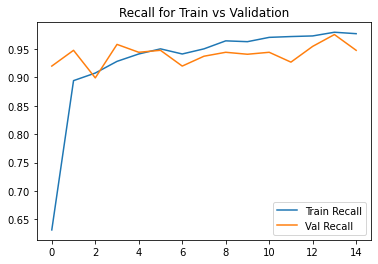

In [35]:
plt.plot(history2.history['recall'], label='Train Recall')
plt.plot(history2.history['val_recall'], label='Val Recall')
plt.title('Recall for Train vs Validation')
plt.legend();

In [36]:
model2.evaluate(test_data)

25/25 [==============================] - 10s 396ms/step - loss: 0.3997 - acc: 0.9125 - recall: 0.9112


[0.3997397720813751, 0.9124839305877686, 0.9111968874931335]

##### Model 3: Trying out Transfer Learning

In [37]:
#load all images
#directory parameter == file path! make sure the relative path is correct!
#create a train dataset from the generator
#create a test dataset for evaluation
#label the batch_size for use later in the code

#data augmentation
image_generator = ImageDataGenerator(rescale = 1./255, validation_split=.15)

test_datagen = ImageDataGenerator(rescale = 1./255)


bat_size = 32

train_data = image_generator.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TRAIN',
                                                 class_mode=None,
                                                 subset = 'training',
                                                 target_size=(256,256),
                                                 shuffle=False,
                                                 batch_size=bat_size)

#create a validation dataset from the generator
val_data = image_generator.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TRAIN',
                                                      class_mode=None,
                                                      subset='validation',
                                                      target_size=(256,256),
                                                      shuffle=False,
                                                      batch_size=bat_size)
#pull in the test data from the directory
test_data = test_datagen.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TEST',
                                            class_mode = None,
                                            target_size = (256,256),
                                            batch_size = bat_size)

Found 2644 images belonging to 3 classes.
Found 465 images belonging to 3 classes.
Found 777 images belonging to 3 classes.


In [38]:
#0 = covid, 1 = Normal, 2 = Viral Penumonia
train_data.class_indices.keys()

dict_keys(['COVID_train', 'NORMAL_train', 'Viral_Pneumonia_train'])

In [41]:
conv_base = InceptionV3(weights = 'imagenet', include_top = False, 
                       input_shape = (256, 256, 3))

In [42]:
#predict features with base
train_features = conv_base.predict(train_data)
val_features = conv_base.predict(val_data)
test_features = conv_base.predict(test_data)

In [43]:
#grab target features
y_train = train_data.labels
y_val = val_data.labels
y_test = test_data.labels

In [44]:
#simple network to pool and classify -- Dense 2!
model3 = Sequential()
model3.add(GlobalAveragePooling2D())
model3.add(Dense(3, activation = 'softmax'))
#compile the model
model3.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['acc', 'Recall'])

In [45]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [46]:
#fit the generator to the model
history3 = model3.fit(train_features, y_train,
                   validation_data = (val_features,y_val),
                   steps_per_epoch = train_data.n//train_data.batch_size,
                   validation_steps = val_data.n//val_data.batch_size,
                   epochs = 15)

Epoch 1/15
82/82 [==============================] - 1s 5ms/step - loss: 0.6401 - acc: 0.7057 - recall: 0.6532 - val_loss: 0.4134 - val_acc: 0.8043 - val_recall: 0.7892
Epoch 2/15
82/82 [==============================] - 0s 3ms/step - loss: 0.2825 - acc: 0.8966 - recall: 0.8910 - val_loss: 0.2429 - val_acc: 0.9097 - val_recall: 0.8968
Epoch 3/15
82/82 [==============================] - 0s 3ms/step - loss: 0.1842 - acc: 0.9411 - recall: 0.9369 - val_loss: 0.2238 - val_acc: 0.9204 - val_recall: 0.9054
Epoch 4/15
82/82 [==============================] - 0s 3ms/step - loss: 0.1761 - acc: 0.9423 - recall: 0.9372 - val_loss: 0.2051 - val_acc: 0.9269 - val_recall: 0.9183
Epoch 5/15
82/82 [==============================] - 0s 3ms/step - loss: 0.1524 - acc: 0.9478 - recall: 0.9446 - val_loss: 0.3192 - val_acc: 0.8753 - val_recall: 0.8710
Epoch 6/15
82/82 [==============================] - 0s 3ms/step - loss: 0.1521 - acc: 0.9451 - recall: 0.9409 - val_loss: 0.2504 - val_acc: 0.9032 - val_recall:

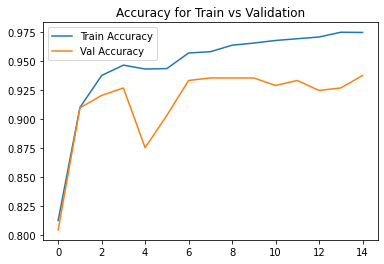

In [47]:
plt.plot(history3.history['acc'], label='Train Accuracy')
plt.plot(history3.history['val_acc'], label='Val Accuracy')
plt.title('Accuracy for Train vs Validation')
plt.legend();

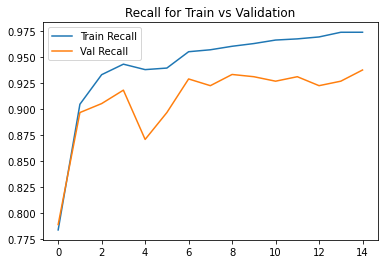

In [48]:
plt.plot(history3.history['recall'], label='Train Recall')
plt.plot(history3.history['val_recall'], label='Val Recall')
plt.title('Recall for Train vs Validation')
plt.legend();

In [49]:
model3.evaluate(test_features, y_test)

25/25 [==============================] - 0s 3ms/step - loss: 4.3181 - acc: 0.3436 - recall: 0.3423


[4.318126201629639, 0.3436293303966522, 0.342342346906662]